# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- commentaires tous en anglais
- virer les prints inutiles

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30

PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [7]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False
[0 0 0 0 0]
False


### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(98, 224), (476, 224), (476, 0), (98, 0)], [(550, 1080), (868, 1080), (868, 604), (550, 604)], [(1063, 1080), (1369, 1080), (1369, 614), (1063, 614)]]
Centroid de la goal area : [1630.5  571.5]
Vecteur direction du robot : 93 -8
Centroid du robot : [364 545]


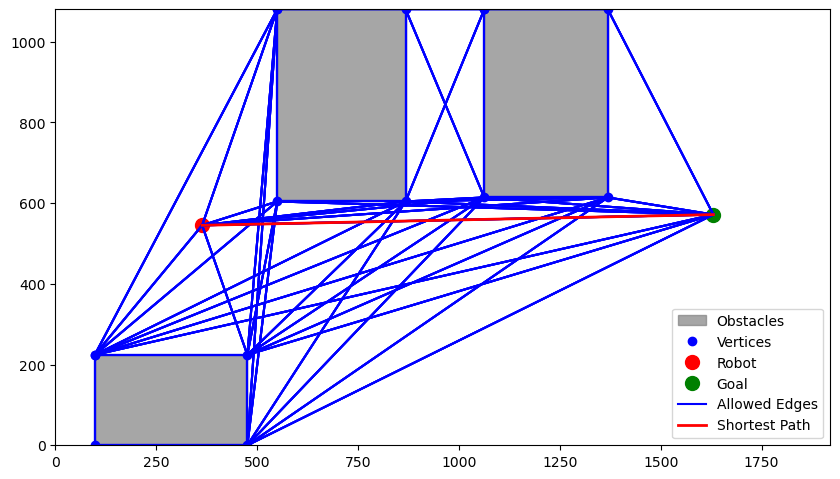

In [14]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

1 rotation
Kalman:  19.00000000000075 28.99999999999995 -0.08581026469650216 0.7700007700007699 0.7700007700007699
[-0.08581026] [0.01449174] [0.100302]
[(88, 30)]
2 rotation
Kalman:  17.2091801185774 28.796661864050627 -0.07164465302256467 0.9680010965375836 -0.31900101566210004
[-0.07164465] [0.01699687] [0.08864152]
[(88, 30)]
3 translation
Kalman:  16.87538470628083 28.76553577211203 -0.0551906704661736 1.2523091847742402 -1.0026940366211021
trabslation: [(88, 30)]
Error: [71.13532739]
4 translation
Kalman:  17.68691690524135 28.804054949693253 -0.009130523859270054 1.4215089790260498 0.6102587609257888
trabslation: [(88, 30)]
Error: [70.32325319]
5 translation
Kalman:  18.365429486671374 28.810271135120956 0.007670932667253306 1.7666453327631018 1.3802550060982317
trabslation: [(88, 30)]
Error: [69.64473322]
6 translation
Kalman:  19.08596183294505 28.817660317499925 0.016607791411372815 1.94949253190257 1.6999271171240393
trabslation: [(88, 30)]
Error: [68.92417996]
7 translation

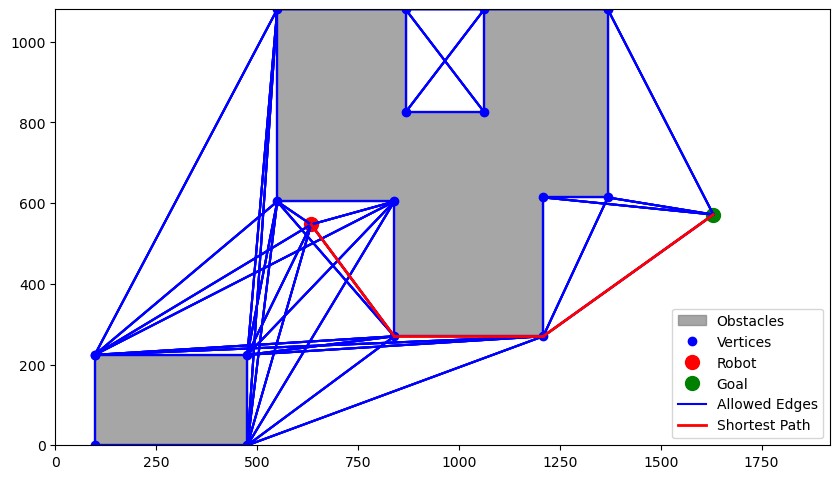

glob nav path : [(634.0, 547.0), (840.0, 270.0), (1209.0, 270.0), (1630.5, 571.5)]
camera measurements:  (34, 29) -0.18468438008645455
centroid camera:  (34, 29)
camera fin: [(45, 14), (65, 14), (88, 30)]
36 rotation
Kalman:  34.00000182015354 29.00002109774895 -0.18414108396074463 -1.5373832623380217 -1.5373080513765984
[-0.18414108] [-0.93804824] [-0.75390716]
[(45, 14), (65, 14), (88, 30)]
37 rotation
Kalman:  33.43661727244057 29.10489350769909 -0.1945520068101743 -1.5977585935163097 -0.6295669867683504
[-0.19455201] [-0.9174243] [-0.7228723]
[(45, 14), (65, 14), (88, 30)]
38 rotation
Kalman:  33.12938247709584 29.163582314654946 -0.24112723558635757 -1.5604080079125504 0.6078238361674206
[-0.24112724] [-0.90660842] [-0.66548118]
[(45, 14), (65, 14), (88, 30)]
39 rotation
Kalman:  33.01009274634073 29.19284504352416 -0.31659727278923755 -1.61563995952969 1.2517984706415932
[-0.31659727] [-0.90268713] [-0.58608986]
[(45, 14), (65, 14), (88, 30)]
40 rotation
Kalman:  32.9625771310669

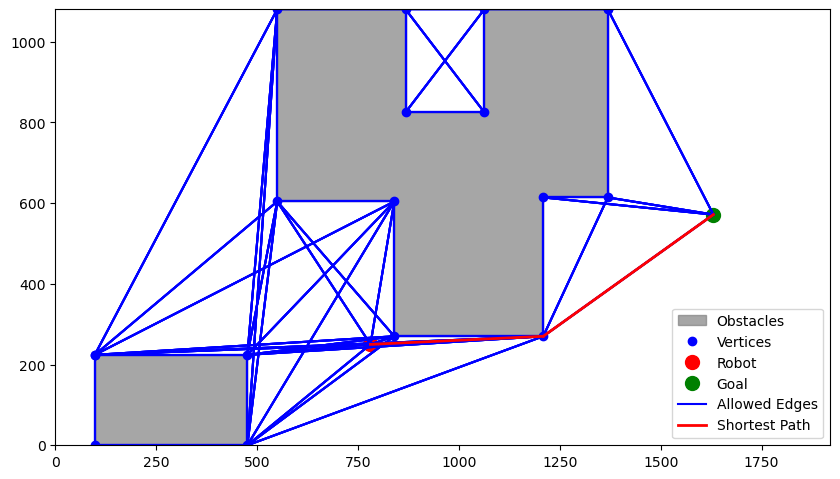

glob nav path : [(781.0, 250.0), (1209.0, 270.0), (1630.5, 571.5)]
camera measurements:  (42, 13) -1.0584068664841588
centroid camera:  (42, 13)
camera fin: [(65, 14), (88, 30)]
73 rotation
Kalman:  42.000166156215364 12.999854451104325 -1.0575715001867634 1.4351778423647552 1.693152547700221
[-1.0575715] [0.04345753] [1.10102903]
[(65, 14), (88, 30)]
74 rotation
Kalman:  42.25170408143346 12.55322237469006 -1.0490137790807004 1.3536454704706438 0.032065513767442155
[-1.04901378] [0.06351384] [1.11252762]
[(65, 14), (88, 30)]
75 rotation
Kalman:  42.34922312583576 12.381229967760348 -0.9920701879922751 1.5694011020639353 -0.9705700522624514
[-0.99207019] [0.07134513] [1.06341531]
[(65, 14), (88, 30)]
76 rotation
Kalman:  42.39210432031949 12.316379736357334 -0.9107652173907176 1.5851635540231035 -1.3563338207568563
[-0.91076522] [0.07433324] [0.98509846]
[(65, 14), (88, 30)]
77 rotation
Kalman:  42.41271621949916 12.290394718031006 -0.8211832610600434 1.625231037705388 -1.5038293471170

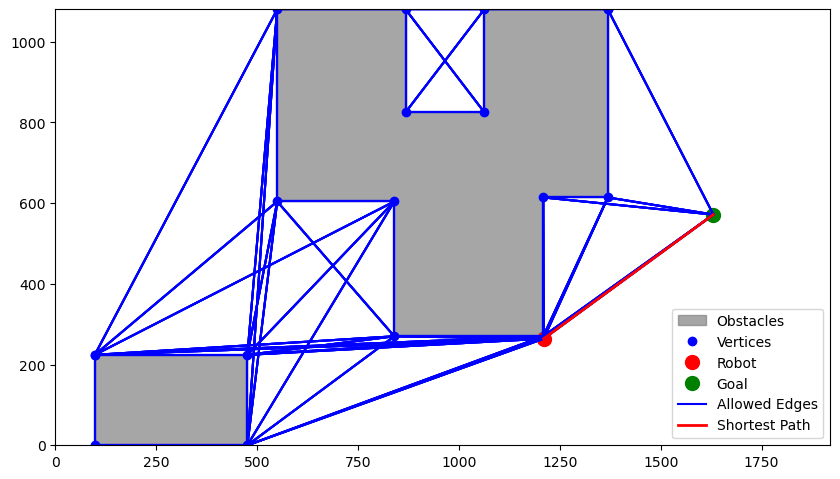

glob nav path : [(1210.0, 264.0), (1630.5, 571.5)]
camera measurements:  (65, 14) -0.07604355927911707
centroid camera:  (65, 14)
camera fin: [(88, 30)]
118 rotation
Kalman:  65.00027671706955 14.000092423026246 -0.07486785789708948 1.3136633934671895 1.8202760953629116
[-0.07486786] [0.60780493] [0.68267279]
[(88, 30)]
119 rotation
Kalman:  65.51158376066095 13.961571099877984 -0.07045667658463772 1.3739518085461786 0.012064787334112426
[-0.07045668] [0.61952107] [0.68997775]
[(88, 30)]
120 rotation
Kalman:  65.70811910511577 13.946519551848235 -0.013687630889299245 1.543326339276835 -0.9447153180862637
[-0.01368763] [0.62412131] [0.63780895]
[(88, 30)]
121 rotation
Kalman:  65.79377992426538 13.945561296482099 0.06667725074738884 1.6091860569366732 -1.312485416580181
[0.06667725] [0.62597654] [0.55929929]
[(88, 30)]
122 rotation
Kalman:  65.83542342234364 13.948849356829154 0.15591396772389718 1.6344070318042097 -1.4870807349345239
[0.15591397] [0.62677072] [0.47085675]
[(88, 30)]
12

CancelledError: 

In [15]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

speed_correction = 14 #calibration cst for rotation counterclockwise

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)



old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # test if local (with proximity)
    if(detected):
        await stop_robot()
        global_state = 'local_avoidance'

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()

    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        print(intermediate_goals)
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise
            speed_correction = 1.0 
        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise
            speed_correction = 1.0 

    elif global_state == 'translation':
        
        print("trabslation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            global_state = 'camera'
            continue
            
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = 'camera'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = 'rotation'
        continue
        
        
        
    elif global_state == 'local_avoidance':
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        print("OBject:", Object)
        print("avant append:", obstacles)
        obstacles.append(Object)
        print("après append:", obstacles)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-50, -50)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
            await client.sleep(0.4)
        
        global_state = "camera"
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [16]:
await stop_robot()